# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### Общая информация

#### Данные

Загружу библиотеки и датасет

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pathlib
from pathlib import Path



#### Общая информация о полученном датафрейме.

Изучу датасет

In [ ]:
real_estate_data.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
18375,18,2800000.0,37.5,2016-05-26T00:00:00,1,2.70,5.0,15.7,1,NaN,...,10.0,NaN,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16637,5,4950000.0,40.0,2017-12-04T00:00:00,1,2.70,26.0,15.0,9,NaN,...,10.6,1.0,посёлок Парголово,53148.0,19325.0,0.0,NaN,0.0,NaN,111.0
5263,12,8750000.0,79.8,2017-11-01T00:00:00,3,2.75,17.0,46.9,6,NaN,...,10.8,1.0,Санкт-Петербург,16600.0,15134.0,1.0,350.0,0.0,NaN,112.0
655,13,10000000.0,68.9,2019-02-20T00:00:00,3,2.50,9.0,40.4,4,NaN,...,8.1,NaN,Санкт-Петербург,40476.0,12170.0,1.0,416.0,2.0,695.0,31.0
22432,4,3999000.0,47.1,2018-06-15T00:00:00,2,NaN,4.0,31.0,2,NaN,...,6.0,NaN,Санкт-Петербург,21417.0,3848.0,0.0,NaN,2.0,229.0,57.0
2301,5,3800000.0,50.4,2017-12-25T00:00:00,2,2.54,9.0,31.4,4,NaN,...,8.2,1.0,Санкт-Петербург,20745.0,17027.0,0.0,NaN,2.0,346.0,84.0
9758,6,1200000.0,30.0,2016-05-27T00:00:00,1,NaN,4.0,18.0,4,NaN,...,6.0,0.0,Кириши,NaN,NaN,NaN,NaN,NaN,NaN,63.0
7194,9,5400000.0,52.0,2017-10-26T00:00:00,2,NaN,12.0,30.0,2,NaN,...,8.0,NaN,Санкт-Петербург,15795.0,16379.0,1.0,203.0,0.0,NaN,193.0
12372,10,8900000.0,70.2,2019-03-13T00:00:00,2,2.90,22.0,30.0,22,NaN,...,30.0,NaN,Санкт-Петербург,29417.0,12278.0,0.0,NaN,1.0,923.0,NaN
2367,20,2750000.0,53.0,2017-04-22T00:00:00,2,NaN,5.0,29.9,3,NaN,...,8.7,0.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,111.0


В сете есть названия столбцов, например, cityCenters_nearest, parks_around3000, которые можно улучшить переписав в "змеином стиле".


В сете нет данных, которые есть в сервисах по продаже недвижимости:
* тип аккаунта (собственник, агент);
* наличие ремонта;
* адресов и соответсвенно районов Санкт-Петербурга, хотя известный факт, что зачастую район может существенно влиять на цену (например, "Золотой треугольник", Петроградская сторона, Крестовский остров);
* тип дома (кирпич, панель, монолит), что также влияет на цену.

Отсутствие данной информации может привести к искажению в выводах при исследовании зависимостей на рынке недвижимости т.к. данные параметры могут влиять на скорость продажи, цену на объект.


Изучу типы данных

In [ ]:
real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — общая площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

Ряд столбцов требует замены типы данных на int64, bool, datatime:
* first_day_exposition
* floors_total
* is_apartment
* balcony
* parks_around3000
* ponds_around3000
* days_exposition

Изучу населенные пункты

In [ ]:
real_estate_data.locality_name.value_counts()

Санкт-Петербург           15721
посёлок Мурино              522
посёлок Шушары              440
Всеволожск                  398
Пушкин                      369
                          ...  
деревня Рапполово             1
деревня Борисова Грива        1
поселок Ромашки               1
деревня Хапо-Ое               1
поселок Гончарово             1
Name: locality_name, Length: 364, dtype: int64

Большая часть объектов недвижимости находится в Санкт-Петербурге, при этом некоторые его районы вынесены в отдельную строку (Пушкин, Шушары). В идеале хорошо бы пункты отделить от их названий, а также убедиться, что нет неявных дублей.

Найду пропущенные значения

In [ ]:
real_estate_data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Есть пропущенные значения. Балконов могло не быть, а пропуски в названии населенного пункта вероятно ошибка выгрузки (Вот что пишет сервис при попытке опубликовать объявление без адреса: "Мы не можем опубликовать объявление без адреса. Нет, серьёзно, как можно продать квартиру без адреса?" По введенному адресу сервис предлагает выбрать населенный пункт)
Есть группы столбцов, например parks_around3000 и ponds_around3000, которые имеют сходные данные по пропускам, что наводит на мысль о том, что выгрузились не все данные, тем более эти данные картографические и как я понимаю заполнялись автоматически, на основании адреса объекта, а не самим пользователем.

Изучу общую статистику

In [ ]:
pd.set_option('float_format', '{:.2f}'.format)

In [ ]:
real_estate_data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.00,23699.00,23699.00,23699.00,14504.00,23613.00,21796.00,23699.00,21421.00,12180.00,18157.00,18180.00,18181.00,8079.00,18181.00,9110.00,20518.00
mean,9.86,6541548.77,60.35,2.07,2.77,10.67,34.46,5.89,10.57,1.15,28793.67,14191.28,0.61,490.80,0.77,517.98,180.89
std,5.68,10887013.27,35.65,1.08,1.26,6.60,22.03,4.89,5.91,1.07,12630.88,8608.39,0.80,342.32,0.94,277.72,219.73
min,0.00,12190.00,12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3400000.00,40.00,1.00,2.52,5.00,18.60,2.00,7.00,0.00,18585.00,9238.00,0.00,288.00,0.00,294.00,45.00
50%,9.00,4650000.00,52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,26726.00,13098.50,0.00,455.00,1.00,502.00,95.00
75%,14.00,6800000.00,69.90,3.00,2.80,16.00,42.30,8.00,12.00,2.00,37273.00,16293.00,1.00,612.00,1.00,729.00,232.00
max,50.00,763000000.00,900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


Есть явные аномалии, сомнительным кажется высота потолков 1м и 100м, 60 этажей в здании не типично для СПб и лен.обл, минимальная жилая площадь 2 кв. м. не соотвествует СНиП, максимальная (763млн.) и минимальная (12тыс.) цена не похожи на рыночную стоимость в Спб и Лен.обл даже с учетом района и ремонта.

#### Общая гистограмма для всех числовых столбцов таблицы.

Построю общую гистограмму для всех числовых столбцов

''

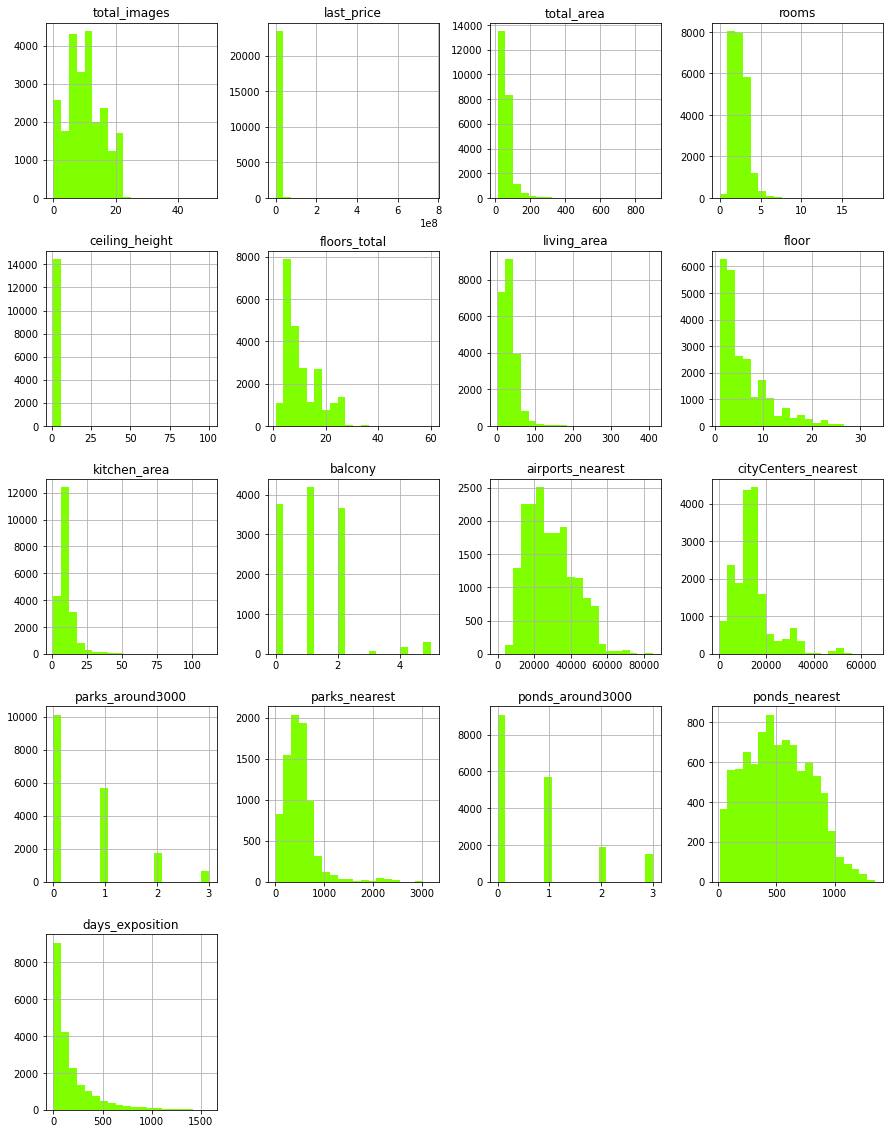

In [ ]:
real_estate_data.hist(bins=20, figsize=(15, 20), color = 'chartreuse')
""


В среднем пользователи размещают порядка 10 фотографий.

Чаще продают квартиры, где 2-3 команаты.

Дома в основном не превышают 12 этажей.

Большая часть квартир располагается не выше 5-го этажа.

Для графиков last_price, ceiling_height информативнее будет другая размерность, построю в основном исследовании.

Предварительно можно сказать, что большая часть квартир имеет площадь менее 100кв.м., при этом жилая площадь менее 50кв.м.

Смущает количество болконов 4 и выше.

Расстояние до центра на графиках порядка 20км, до аэропрта от 10 до 60км. В сете большая часть объектов из СПб, аэропорт находится на юге города, из северной точки, например, Парнас до аэропорта 53км. Поэтому расстояние в данных до центра и аэропорта вполне правдоподобно.

Примерно 70 дней уходит на продажу квартиры.

<div style="border:solid Purple 2px; padding: 40px">
    Вывод. Часть признаков отсутсвует. Есть пропуски. Не все типы данных верно определены. Можно улучшить стиль названия столбцов.
    </div>

### Предобработка данных

#### Дубликаты

Проверю наличие явных дубликатов

In [ ]:
print('Число дубликатов:', real_estate_data.duplicated().sum())

Число дубликатов: 0


Исходя из сути сета неявные дубликаты могут быть в колонке locality_name

In [ ]:
real_estate_data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Удалю неявный дубль 'поселок' на 'посёлок'


In [ ]:
real_estate_data['locality_name']=real_estate_data['locality_name'].str.replace('поселок', 'посёлок')

Согласно Закону Ленинградской области «Об административно-территориальном устройстве Ленинградской области и порядке его изменения» «… городской посёлок (посёлок городского типа) — населённый пункт со смешанной застройкой, имеющий развёрнутую сферу обслуживания и промышленное производство, с численностью населения от 3000 до 12 000 человек…»
Сделаю замену 'городской посёлок' на 'посёлок городского типа'

In [ ]:
real_estate_data['locality_name']=real_estate_data['locality_name'].str.replace('городской посёлок', 'посёлок городского типа')

В коттеджных посёлках могут располагаться таунхаусы с квартирами, но сами коттеджные посёлки располагаются в деревнях, посёлках и т.д.
В сете уже есть, например, городской посёлок Фёдоровское, в нем находится коттеджный посёлок Счастье. Сделаю замены

In [ ]:
real_estate_data['locality_name']=real_estate_data['locality_name'].str.replace('коттеджный посёлок Счастье', 'городской посёлок Фёдоровское')

In [ ]:
real_estate_data['locality_name']=real_estate_data['locality_name'].str.replace('коттеджный посёлок Кивеннапа Север', 'посёлок Первомайское')

In [ ]:
 real_estate_data['locality_name']=real_estate_data['locality_name'].str.replace('коттеджный посёлок Лесное', 'деревня Малые Горки')

Проверю результат

In [ ]:
real_estate_data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской посёлок Фёдоровское', 'деревня Агалатово',
       'деревня Аро', 'деревня Батово', 'деревня Бегуницы',
       'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       '

В садовых товариществах можно регистрировать садовые дома, квартир быть не может. Видимо это ошибка и возможно стоит удалить данные строки.

#### Редкие значения

Изучу высоту потолков

In [ ]:
real_estate_data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Потолок не может быть ниже 2,4м (такая высота в хрущевке, считается, что здесь самые низкие потолки), если только это не антресоль в двухуровневой квартире. Самые высокие потолки в старом фонде достигают 11м, такие же потолки могут встречаться в современном доме, с двухуровневыми квартирами. Значения 14; 20; 22,6 - вызывают большие сомнения. Значения 24м и выше выглядит как опечатка, значение можно разделить на 10 и получить 2,4м.

In [ ]:
real_estate_data.loc[real_estate_data['ceiling_height']>=24, 'ceiling_height']= real_estate_data['ceiling_height']/10


Изучу какие теперь выбросы покажет box plot

<AxesSubplot:xlabel='ceiling_height'>

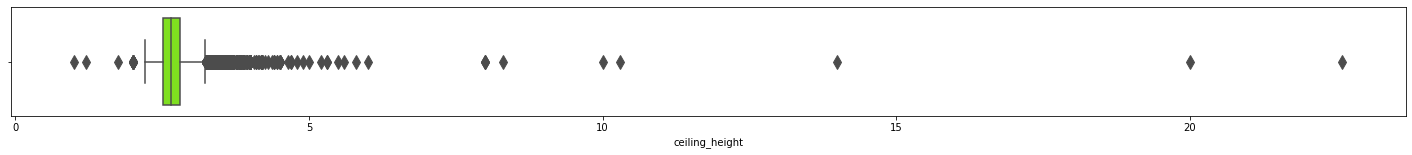

In [ ]:
plt.figure(figsize=(25,2))
sns.boxplot(x=real_estate_data['ceiling_height'],fliersize=10, color='chartreuse')

Рассчитаю выбросы (Q1 и Q3 беру из первой части)


In [ ]:
Q1=2.52
Q3=2.8
lo=Q1-1.5*(Q3-Q1)
ro=Q3+1.5*(Q3-Q1)
print('left_outliers', round(lo,2))
print('rigth_outliers', round(ro,2))

left_outliers 2.1
rigth_outliers 3.22


Потолки ниже 2,1м и выше 3,22 являются выбросами.

В сете почти половина строк не содержит высоту потолка (9195*100/23699=38,8%), что не мало.
Посмотрю как много данных при значении потолков менее 2,4м

Изучу строки с низкими значениями

In [ ]:
print(real_estate_data.query('ceiling_height < 2.40'))

       total_images  last_price  total_area first_day_exposition  rooms  \
227              13  2200000.00       47.00  2018-01-12T00:00:00      3   
552              11  2999000.00       33.50  2017-03-30T00:00:00      1   
1582              4  4100000.00       45.60  2016-01-13T00:00:00      2   
2572              4  2400000.00       62.00  2018-12-27T00:00:00      3   
4212              1  2120000.00       35.43  2017-12-18T00:00:00      1   
5498             17  2200000.00       56.00  2018-04-02T00:00:00      2   
5712              5  1500000.00       42.80  2017-08-14T00:00:00      2   
5850              9  1650000.00       35.50  2018-05-29T00:00:00      1   
11352             4  3300000.00       36.00  2017-06-18T00:00:00      1   
12755             2  1400000.00       22.50  2017-09-21T00:00:00      1   
16446             6 12300000.00       88.30  2019-03-12T00:00:00      3   
16884             0  1500000.00       33.00  2018-10-03T00:00:00      1   
16934             5  4100

23 строки из 23699 , в виду того, что это одновременно выбросы и неправдоподобные данные такие строки лучше удалить

In [ ]:
#real_estate_data = real_estate_data.query('ceiling_height >=2.40 or ceiling_height.isna()')



    
<div class="alert alert-info">
<b>Комментарий студента:</b>
<br> в строке [22] поставила # т.к. ниже по твоей просьбе буду делать замену на медиану
</div>

Изучу цену на момент снятия с публикации

Построю гистограмму

Text(0.5, 1.0, 'Last price')

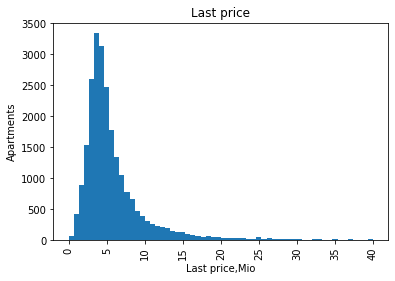

In [ ]:
plt.hist(x = real_estate_data['last_price']/1000000, bins=60, range = (0, 40))
plt.xlabel('Last price,Mio')
plt.ylabel('Apartments')
plt.xticks(rotation=90)
plt.title('Last price')

На правой части графика видны выбросы

Посторю box plot

Text(0.5, 1.0, 'Outliers, Mio')

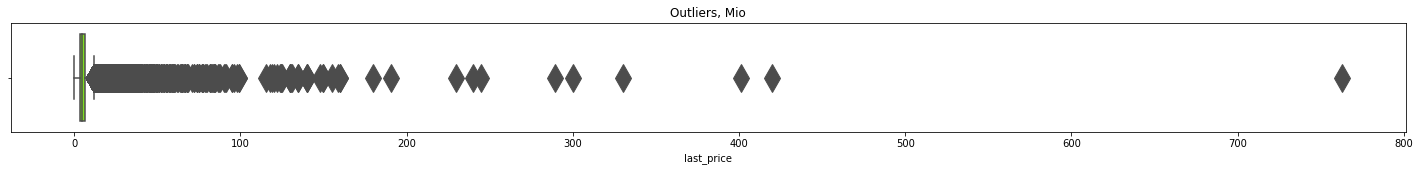

In [ ]:
plt.figure(figsize=(25,2))

sns.boxplot(x=(real_estate_data['last_price']/1000000), fliersize=20, color='chartreuse')
plt.title('Outliers, Mio')


В правой части очень много выбросов

In [ ]:
Q1=3400000
Q3=6800000
lo=Q1-1.5*(Q3-Q1)
ro=Q3+1.5*(Q3-Q1)
print('left_outliers', round(lo,2))
print('rigth_outliers', round(ro,2))

left_outliers -1700000.0
rigth_outliers 11900000.0


Изучу объекты дороже 11 900 000 руб.

In [ ]:
real_estate_data.query('last_price >=11900000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
19,16,14200000.00,121.00,2019-01-09T00:00:00,3,2.75,16.00,76.00,8,NaN,...,12.00,NaN,Санкт-Петербург,38900.00,12843.00,0.00,NaN,0.00,NaN,97.00
35,6,15500000.00,149.00,2017-06-26T00:00:00,5,NaN,5.00,104.00,4,NaN,...,17.00,NaN,Санкт-Петербург,23670.00,3502.00,0.00,NaN,1.00,779.00,644.00
42,13,22000000.00,161.80,2015-07-08T00:00:00,4,2.80,4.00,80.90,2,False,...,17.60,5.00,Петергоф,35416.00,30605.00,2.00,47.00,1.00,907.00,987.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23587,7,12100000.00,88.00,2017-07-07T00:00:00,3,NaN,10.00,NaN,5,NaN,...,14.00,NaN,Санкт-Петербург,37412.00,8370.00,1.00,392.00,2.00,359.00,200.00
23590,0,21187872.00,123.30,2017-04-25T00:00:00,3,NaN,NaN,50.40,18,NaN,...,23.60,0.00,Санкт-Петербург,19095.00,4529.00,0.00,NaN,0.00,NaN,104.00
23608,22,14000000.00,80.00,2017-11-10T00:00:00,3,NaN,11.00,44.10,6,NaN,...,11.00,2.00,Санкт-Петербург,11943.00,11710.00,1.00,518.00,1.00,232.00,19.00
23631,17,14799000.00,104.00,2018-11-18T00:00:00,3,3.10,4.00,66.00,2,NaN,...,14.00,1.00,Санкт-Петербург,39047.00,13944.00,0.00,NaN,1.00,553.00,90.00


In [ ]:
print('Процент выбросов', 2060*100/23699)

Процент выбросов 8.692349888180935


Достаточной высокий процент выбросов. Это должно быть жилье сегмента premium, его лучше выносить в отдельный сет, т.к. привычки и возможности middle class отличаются от wealthy class, не стоит все усреднять.

In [ ]:
real_estate_data['last_price'].sort_values(ascending=False).head(10)

12971   763000000.00
19540   420000000.00
14706   401300000.00
1436    330000000.00
15651   300000000.00
22831   289238400.00
16461   245000000.00
13749   240000000.00
5893    230000000.00
8900    190870000.00
Name: last_price, dtype: float64

In [ ]:
real_estate_data.loc[[12971, 19540, 14706, 1436, 8900]]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000.00,400.00,2017-09-30T00:00:00,7,NaN,10.00,250.00,10,NaN,...,NaN,2.00,Санкт-Петербург,25108.00,3956.00,1.00,530.00,3.00,756.00,33.00
19540,8,420000000.00,900.00,2017-12-06T00:00:00,12,2.80,25.00,409.70,25,NaN,...,112.00,NaN,Санкт-Петербург,30706.00,7877.00,0.00,NaN,2.00,318.00,106.00
14706,15,401300000.00,401.00,2016-02-20T00:00:00,5,NaN,9.00,204.00,9,False,...,24.00,3.00,Санкт-Петербург,21912.00,2389.00,1.00,545.00,1.00,478.00,393.00
1436,19,330000000.00,190.00,2018-04-04T00:00:00,3,3.50,7.00,95.00,5,NaN,...,40.00,NaN,Санкт-Петербург,23011.00,1197.00,3.00,519.00,3.00,285.00,233.00
8900,13,190870000.00,268.00,2016-03-25T00:00:00,3,NaN,8.00,132.00,7,NaN,...,40.00,NaN,Санкт-Петербург,32440.00,5297.00,0.00,NaN,2.00,198.00,901.00


Цена 763млн.руб. за 400кв.м. выглядит весьма завышенной по сравнению с другими, хотя если в квартире при ремонте использовали редкие породы дерева, камня и ее выставляют с мебелью, то все может быть. Не похоже что пользователь ошибся нулем, т.к. в сете есть квартира 190кв.м. за 330млн.руб.

Удалю этот выброс

In [ ]:
real_estate_data = real_estate_data.query('last_price != 763000000.00 or last_price.isna()')

Посмотрю нижние границы

In [ ]:
real_estate_data['last_price'].sort_values(ascending=True).head(10)

8793     12190.00
17456   430000.00
14911   430000.00
16274   440000.00
17676   450000.00
5698    450000.00
16219   450000.00
9581    450000.00
18867   470000.00
21912   470000.00
Name: last_price, dtype: float64

430000 - стартовая стоимость квартиры в Лен. обл. В СПб квартиры дороже, поэтому стоит делить выгрузки и изучать отдельно область от города.

12190 - выглядит нереальной ценой, удалю строку

In [ ]:
real_estate_data = real_estate_data.query('last_price != 12190.00 or last_price.isna()')

В сете были данные с объектами недвижимости выше 34 этажей, чего для СПб быть не может. Проверю их наличие сейчас

In [ ]:
real_estate_data.query('floors_total>35.00')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
397,15,5990000.00,54.00,2018-03-22T00:00:00,2,NaN,36.00,21.40,28,NaN,...,18.70,1.00,Санкт-Петербург,18732.00,20444.00,0.00,NaN,3.00,80.00,11.00
2253,12,3800000.00,45.50,2018-06-28T00:00:00,2,2.88,60.00,27.40,4,NaN,...,7.40,NaN,Кронштадт,67763.00,49488.00,2.00,342.00,3.00,614.00,166.00
5807,17,8150000.00,80.00,2019-01-09T00:00:00,2,2.70,36.00,41.00,13,NaN,...,12.00,5.00,Санкт-Петербург,18732.00,20444.00,0.00,NaN,3.00,80.00,38.00
11079,16,9200000.00,75.00,2019-02-22T00:00:00,2,2.70,36.00,40.00,29,NaN,...,12.00,2.00,Санкт-Петербург,18732.00,20444.00,0.00,NaN,3.00,80.00,NaN
16731,9,3978000.00,40.00,2018-09-24T00:00:00,1,2.65,52.00,10.50,18,NaN,...,14.00,NaN,Санкт-Петербург,20728.00,12978.00,1.00,793.00,0.00,NaN,45.00
16934,5,4100000.00,40.00,2017-10-17T00:00:00,1,1.75,37.00,17.40,5,NaN,...,8.34,NaN,Санкт-Петербург,18732.00,20444.00,0.00,NaN,3.00,80.00,71.00


Удалю объекты выше 35 этажей

In [ ]:
real_estate_data = real_estate_data.query('floors_total <= 35.00 or floors_total.isna()')

Изучу минимальную жилую площадь

In [ ]:
real_estate_data.query('living_area<8.00')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000.00,41.00,2017-07-02T00:00:00,1,NaN,17.00,3.00,17,NaN,...,11.00,NaN,Санкт-Петербург,19272.00,13073.00,0.00,NaN,0.00,NaN,216.00
13915,20,6350000.00,52.00,2018-02-06T00:00:00,2,3.00,6.00,2.00,2,NaN,...,9.00,NaN,Санкт-Петербург,32453.00,6521.00,0.00,NaN,1.00,1012.00,91.00
16431,13,3799000.00,31.00,2018-04-12T00:00:00,1,2.60,5.00,6.00,1,NaN,...,17.00,NaN,Санкт-Петербург,32177.00,4826.00,1.00,430.00,0.00,NaN,168.00
17582,11,2680000.00,22.00,2018-08-11T00:00:00,0,NaN,25.00,5.00,8,NaN,...,NaN,2.00,Санкт-Петербург,22735.00,11618.00,1.00,835.00,1.00,652.00,70.00
19251,19,4050000.00,33.00,2018-10-15T00:00:00,1,2.50,22.00,6.50,21,NaN,...,18.00,NaN,Санкт-Петербург,9258.00,10592.00,1.00,458.00,0.00,NaN,44.00
21758,0,2330000.00,23.00,2018-01-01T00:00:00,0,NaN,24.00,2.00,22,NaN,...,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.00
21943,15,6100000.00,77.60,2019-02-28T00:00:00,4,2.50,9.00,5.40,1,NaN,...,9.80,NaN,Санкт-Петербург,29338.00,11270.00,1.00,584.00,0.00,NaN,33.00
23574,14,64990000.00,139.00,2015-11-24T00:00:00,3,3.00,8.00,3.00,8,NaN,...,16.00,1.00,Санкт-Петербург,33255.00,5975.00,1.00,630.00,3.00,100.00,280.00


Возможно пользователи перепутали кухню и жилую площадь, но в любом случае кухня по СНиПу должна быть не менее 6м, в данных есть значения 0,2,3кв.м или, например, при стоимости 64,9млн жилая площадь 3кв.м, кухня 16кв.м., что очень сомнительно. Строк всего восемь, удалю их.

In [ ]:
real_estate_data = real_estate_data.query('living_area >= 8.00 or living_area.isna()')

Построю box plot

Text(0.5, 1.0, 'Outliers')

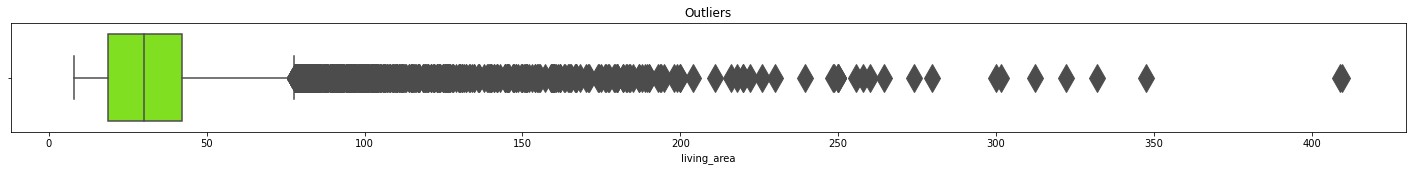

In [ ]:
plt.figure(figsize=(25,2))

sns.boxplot(x=(real_estate_data['living_area']), fliersize=20, color='chartreuse')
plt.title('Outliers')

Квартиры с жилой площадью более 80кв.м. выглядят как выбросы, как писала ранее такие объекты лучше рассматривать как отдельный сегмент.

Изучу общую площадь

Самая маленькая квартира-студия 18 кв.м. Посмотрю на строки с такими значениями.

In [ ]:
real_estate_data.query('total_area<18')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
716,5,1500000.00,17.00,2017-06-07T00:00:00,0,2.70,9.00,12.00,1,NaN,...,NaN,0.00,посёлок Шушары,18654.00,29846.00,0.00,NaN,0.00,NaN,40.00
8886,10,2450000.00,15.50,2018-08-22T00:00:00,0,NaN,5.00,10.00,2,NaN,...,NaN,NaN,Санкт-Петербург,24326.00,4589.00,0.00,NaN,1.00,446.00,27.00
9157,0,3400000.00,17.60,2018-03-18T00:00:00,1,NaN,5.00,15.00,2,NaN,...,NaN,NaN,Санкт-Петербург,21555.00,1967.00,2.00,336.00,1.00,309.00,117.00
9412,5,2100000.00,16.00,2017-12-10T00:00:00,0,NaN,6.00,13.00,1,NaN,...,NaN,NaN,Санкт-Петербург,20735.00,2111.00,2.00,228.00,3.00,72.00,3.00
10208,3,1900000.00,17.00,2018-08-14T00:00:00,1,2.75,4.00,13.00,2,False,...,3.00,NaN,Санкт-Петербург,25072.00,5639.00,0.00,NaN,0.00,NaN,7.00
12040,5,1900000.00,15.00,2018-06-27T00:00:00,1,2.50,5.00,NaN,1,NaN,...,NaN,NaN,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.00
16949,9,1550000.00,15.00,2018-08-21T00:00:00,1,2.70,9.00,NaN,1,NaN,...,NaN,NaN,Санкт-Петербург,51048.00,16376.00,0.00,NaN,1.00,1079.00,42.00
17961,3,1400000.00,13.00,2017-12-03T00:00:00,1,2.60,9.00,NaN,1,NaN,...,NaN,NaN,Санкт-Петербург,14350.00,15945.00,0.00,NaN,1.00,185.00,410.00
19546,3,1850000.00,13.00,2019-03-11T00:00:00,1,3.40,5.00,NaN,2,False,...,NaN,NaN,Санкт-Петербург,24915.00,5483.00,1.00,644.00,0.00,NaN,24.00
19558,2,1686000.00,13.20,2018-12-17T00:00:00,1,NaN,5.00,NaN,1,NaN,...,NaN,NaN,Санкт-Петербург,19891.00,4165.00,1.00,361.00,1.00,155.00,19.00


Удалю значения менее 18кв.м.

Выведу строки, где кухня менее 5 кв.м.

In [ ]:
real_estate_data.query('kitchen_area<5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
76,12,2800000.00,55.10,2016-05-14T00:00:00,3,2.60,5.00,38.40,1,NaN,...,4.90,NaN,Кировск,NaN,NaN,NaN,NaN,NaN,NaN,606.00
298,9,2650000.00,42.80,2017-04-25T00:00:00,2,NaN,5.00,30.00,3,NaN,...,4.50,0.00,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,49.00
422,8,1700000.00,55.20,2018-03-24T00:00:00,3,2.50,5.00,38.50,5,NaN,...,4.50,NaN,Кириши,NaN,NaN,NaN,NaN,NaN,NaN,NaN
906,15,2600000.00,27.00,2017-07-10T00:00:00,1,2.75,23.00,18.00,18,NaN,...,2.00,0.00,Санкт-Петербург,22131.00,17459.00,0.00,NaN,1.00,411.00,10.00
1327,6,2650000.00,46.20,2016-12-01T00:00:00,2,2.50,5.00,29.20,5,NaN,...,4.90,NaN,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,704.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22839,14,3350000.00,27.00,2018-11-03T00:00:00,1,2.70,16.00,NaN,6,False,...,4.00,2.00,Санкт-Петербург,41935.00,9551.00,0.00,NaN,0.00,NaN,35.00
22849,6,2380000.00,25.00,2016-03-22T00:00:00,1,NaN,25.00,19.00,15,NaN,...,4.00,1.00,посёлок Шушары,13461.00,19247.00,0.00,NaN,1.00,351.00,140.00
23110,1,2900000.00,34.00,2018-02-01T00:00:00,2,2.90,2.00,20.00,1,NaN,...,4.00,NaN,посёлок Стрельна,27006.00,23832.00,0.00,NaN,2.00,872.00,196.00
23498,7,1600000.00,54.00,2016-12-26T00:00:00,2,2.30,1.00,33.00,1,False,...,3.50,0.00,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,281.00


В объявлениях все выглядит реалистично, кроме размера кухни менее 5кв.м. Удалю эти строки

In [ ]:
real_estate_data = real_estate_data.query('kitchen_area >= 5.00 or kitchen_area.isna()')

Выведу строки с количеством балконов более 3х

In [ ]:
real_estate_data.query('balcony>3.00')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
41,16,7900000.00,74.00,2016-05-04T00:00:00,3,NaN,14.00,59.00,8,False,...,12.00,5.00,Санкт-Петербург,37715.00,12612.00,1.00,725.00,1.00,759.00,179.00
42,13,22000000.00,161.80,2015-07-08T00:00:00,4,2.80,4.00,80.90,2,False,...,17.60,5.00,Петергоф,35416.00,30605.00,2.00,47.00,1.00,907.00,987.00
116,18,10999000.00,97.20,2017-11-13T00:00:00,3,2.50,16.00,NaN,16,NaN,...,18.30,5.00,Санкт-Петербург,19426.00,21138.00,0.00,NaN,2.00,390.00,394.00
121,20,33000000.00,180.00,2017-02-17T00:00:00,3,2.90,9.00,86.00,8,False,...,24.00,4.00,Санкт-Петербург,25689.00,4264.00,1.00,633.00,0.00,NaN,144.00
250,13,3200000.00,51.70,2019-01-22T00:00:00,2,2.65,16.00,29.20,5,NaN,...,7.70,4.00,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23363,10,4300000.00,52.00,2019-04-21T00:00:00,1,2.70,16.00,28.00,8,False,...,11.00,5.00,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23474,16,5900000.00,40.50,2019-03-16T00:00:00,2,2.73,17.00,31.00,16,NaN,...,5.00,4.00,Санкт-Петербург,19901.00,21613.00,0.00,NaN,1.00,1003.00,NaN
23497,17,6150000.00,55.40,2019-04-22T00:00:00,2,2.80,20.00,29.40,16,NaN,...,9.60,4.00,Санкт-Петербург,16285.00,13873.00,0.00,NaN,1.00,481.00,NaN
23526,14,5800000.00,60.69,2018-03-13T00:00:00,3,2.50,9.00,39.70,2,NaN,...,6.20,5.00,Санкт-Петербург,51239.00,15954.00,0.00,NaN,0.00,NaN,30.00


Число балкнов более 4х встречается в квартирах площадью 40-60кв.м. и вызывает сомнения. Моя гипотеза - само по себе наличие балкона может играть роль при продаже квартиры, но количество балконов уже не имеет столь важного значения. Оставлю как есть.

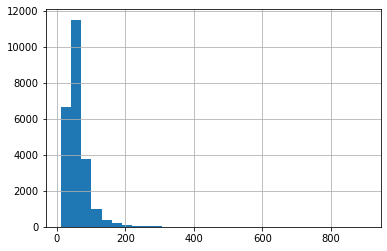

In [ ]:
#код ревьюера
data2 = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
(data2['total_area']).hist(bins=30);

Text(0.5, 1.0, 'Outliers')

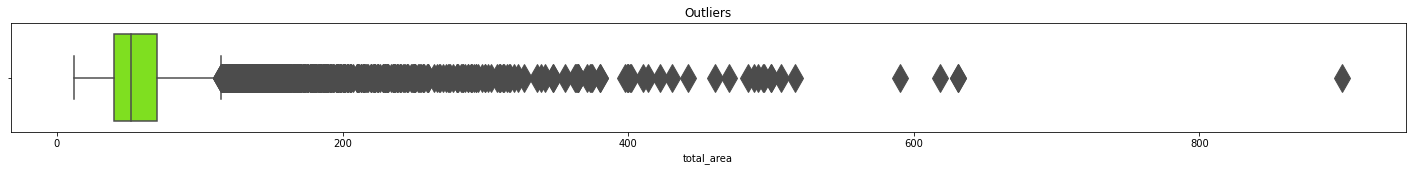

In [ ]:
plt.figure(figsize=(25,2))

sns.boxplot(x=(real_estate_data['total_area']), fliersize=20, color='chartreuse')
plt.title('Outliers')

In [ ]:
real_estate_data = real_estate_data.query('total_area < 200.00 or total_area.isna()')

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br> Изучу число комнат
</div>

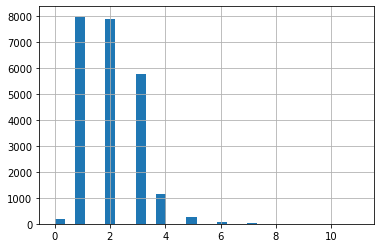

In [ ]:
(real_estate_data ['rooms']).hist(bins=30);

Есть аномальное значене равное нулю, а также выбросы.

Построю box plot

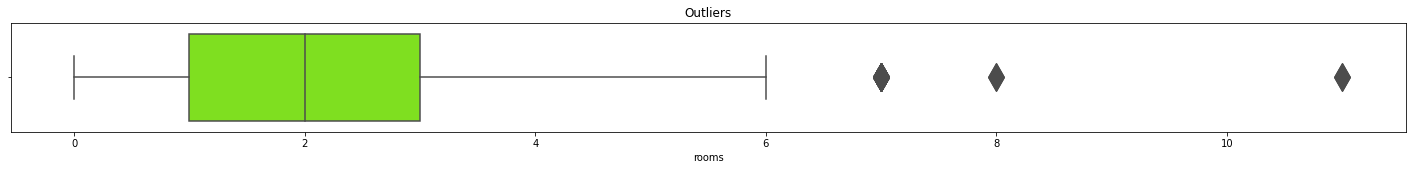

In [ ]:
plt.figure(figsize=(25,2))

sns.boxplot(x=(real_estate_data['rooms']), fliersize=20, color='chartreuse')
plt.title('Outliers');

Удалю квартиры, где указано 0 комнат или свыше 6

In [ ]:
real_estate_data = real_estate_data.query('rooms >= 1 and rooms<6 or rooms.isna()')

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v2:</b>
<br>Отлично! Теперь всё верно)
</div>

#### Типы данных

Заменю в дате публикации формат на более подходящий

In [ ]:
real_estate_data['first_day_exposition'] = pd.to_datetime(real_estate_data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
real_estate_data['first_day_exposition'].dtypes

dtype('<M8[ns]')

In [ ]:
 np.dtype('datetime64[ns]') == np.dtype('<M8[ns]') #проверяю верно ли произошла замена типа данных

True

Всего этажей в доме должно быть целым числом

In [ ]:
real_estate_data['floors_total'] = real_estate_data['floors_total'].astype('Int64')
real_estate_data['floors_total'].dtypes

Int64Dtype()

Этаж соотвественно тоже целое число

In [ ]:
real_estate_data['floor'] = real_estate_data['floor'].astype('Int64')
real_estate_data['floor'].dtypes

Int64Dtype()

Является ли объект апартаментами лучше предствить в булевом типе

In [ ]:
real_estate_data['is_apartment'] = real_estate_data['is_apartment'].fillna(0).astype(bool)
real_estate_data['is_apartment'].dtypes

dtype('bool')

Количество балконов - целое число

In [ ]:
real_estate_data['balcony'] = real_estate_data['balcony'].astype('Int64')
real_estate_data['balcony'].dtypes

Int64Dtype()

Число парков меняю на целое число

In [ ]:
real_estate_data['parks_around3000'] = real_estate_data['parks_around3000'].astype('Int64')
real_estate_data['parks_around3000'].dtypes

Int64Dtype()

Число водоемов меняю на целое число

In [ ]:
real_estate_data['ponds_around3000'] = real_estate_data['ponds_around3000'].astype('Int64')
real_estate_data['ponds_around3000'].dtypes

Int64Dtype()

 Приведу к целому числу количество дней, со дня публикации до снятия

In [ ]:
real_estate_data['days_exposition'] = real_estate_data['days_exposition'].round().astype('Int64')
real_estate_data['days_exposition'].dtypes

Int64Dtype()

In [ ]:
real_estate_data['last_price'] = real_estate_data['last_price'].round().astype('Float32')
real_estate_data['last_price'].dtypes

Float32Dtype()

#### Пропущенные значения в столбцах

In [ ]:
real_estate_data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           8936
floors_total               80
living_area              1855
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2045
balcony                 11206
locality_name              49
airports_nearest         5417
cityCenters_nearest      5397
parks_around3000         5396
parks_nearest           15254
ponds_around3000         5396
ponds_nearest           14288
days_exposition          3070
dtype: int64

* ceiling_height. Данное поле скорее всего не являлось обязательным для заполнения, хотя на всякий случай лучше проверить, не является ли это ошибкой выгрузки. Пропусков слишком много, заменить медианой не лучшая идея в этом случае.

* floors_total. Пропущенных значений не много, удалю.

In [ ]:
real_estate_data = real_estate_data.dropna(subset=['floors_total'])

* locality_name. Выведу эти строки

In [ ]:
print(real_estate_data.loc[real_estate_data['locality_name'].isnull()])

       total_images  last_price  total_area first_day_exposition  rooms  \
1097              3  8600000.00       81.70           2016-04-15      3   
2033              6  5398000.00       80.00           2017-05-30      3   
2603             20  3351765.00       42.70           2015-09-20      1   
2632              2  5130593.00       62.40           2015-10-11      2   
3574             10  4200000.00       46.50           2016-05-28      2   
4151             17 17600000.00       89.50           2014-12-09      2   
4189              7  9200000.00       80.00           2015-12-10      3   
4670              1  5500000.00       83.00           2015-08-14      3   
5343             19 13540000.00       85.50           2016-01-20      3   
5707              7  3700000.00       30.00           2016-04-29      1   
6765             20  4895892.00       60.70           2015-03-12      2   
7114              5  4250000.00       56.00           2016-03-16      3   
7330              8  5100

В целом они адекватно заполнены, кроме тех, где нет расстояния до центра и аэропорта. Если данные точно по СПб и Лен.обл. и это просто ошибка выгрузки, то можно было бы осавить строки для дальнейшего анализа при поиски корреляций разных признаков, но  из-за сбоя могли подгрузиться данные другого региона, поэтому лучше удалть все строки.

In [ ]:
real_estate_data = real_estate_data.dropna(subset=['locality_name'])

* balcony. Предполагаю, если пользователь не заполнил данное поле, то просто балкона нет, сделаю замену, проставлю нули.

In [ ]:
real_estate_data['balcony']=real_estate_data['balcony'].fillna(0)

* living_area,  kitchen_area. На предыдущем шаге было замечено,есть вероятность того, что пользователи путали площадь кухни и комнаты. Не стоит заменять медианным значением.

* kitchen_area, airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000, days_exposition. Эти пропуски можно было бы заполнить медианой, но в нашем сете есть не только СПб, но и Лен. обл., для каждого их них лучше брать свою медиану.

Пока вижу неудобные названия в столбцах переимениую в змеиный регистр

In [ ]:
real_estate_data.rename(columns = {'cityCenters_nearest': 'city_сenters_nearest', 'parks_around3000': 'parks_around_3000', 'ponds_around3000': 'ponds_around_3000'}, inplace = True)
real_estate_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,25.00,0,Санкт-Петербург,18863.00,16028.00,1,482.00,2,755.00,<NA>
1,7,3350000.00,40.40,2018-12-04,1,NaN,11,18.60,1,False,...,11.00,2,посёлок Шушары,12817.00,18603.00,0,NaN,0,NaN,81
2,10,5196000.00,56.00,2015-08-20,2,NaN,5,34.30,4,False,...,8.30,0,Санкт-Петербург,21741.00,13933.00,1,90.00,2,574.00,558
3,0,64900000.00,159.00,2015-07-24,3,NaN,14,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.00,6800.00,2,84.00,3,234.00,424
4,2,10000000.00,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,41.00,0,Санкт-Петербург,31856.00,8098.00,2,112.00,1,48.00,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.00,133.81,2017-03-21,3,3.70,5,73.30,3,False,...,13.83,0,Санкт-Петербург,24665.00,4232.00,1,796.00,3,381.00,<NA>
23695,14,3100000.00,59.00,2018-01-15,3,NaN,5,38.00,4,False,...,8.50,0,Тосно,NaN,NaN,<NA>,NaN,<NA>,NaN,45
23696,18,2500000.00,56.70,2018-02-11,2,NaN,3,29.70,1,False,...,NaN,0,село Рождествено,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>
23697,13,11475000.00,76.75,2017-03-28,2,3.00,17,NaN,12,False,...,23.30,2,Санкт-Петербург,39140.00,10364.00,2,173.00,3,196.00,602


* parks_nearest, ponds_nearest. Слишком много пропусков, не стоит ни чем заменять.

* days_exposition. Продублирую статитстику

In [ ]:
real_estate_data['days_exposition'].describe()

count   19879.00
mean      180.04
std       218.53
min         1.00
25%        45.00
50%        95.00
75%       230.00
max      1580.00
Name: days_exposition, dtype: float64

Очень высокий разрыв между средним и медианой (180 дней и 95 дней соответсвенно) Не вижу смысла удалять пропуски, предстоит изучить корреляцию разных признаков друг с другом.

<div style="border:solid Purple 2px; padding: 40px">
    Вывод. Выявлены и заменены неявные дубликаты. Сделаны замены в типах данных. Часть редких и аномальных значений были удалены. Часть пропусков были удалены. Подобные сеты лучше выгружать в разрезе СПб и Лен. обл. отдельно. Также делить сеты на сегменты econom и premium, что бы элитная недвижимость не являлась выбросом.
    </div>

Заполню пропуски в столбце с высотой потолков, можно достаточно точно их восстановить так как основная часть данных в этом столбце находится в небольшом диапазоне.

In [ ]:
(real_estate_data['ceiling_height'].isna().sum()/len(real_estate_data['ceiling_height'])).round(2) * 100

38.0

In [ ]:
real_estate_data['ceiling_height'].describe()

count   14111.00
mean        2.72
std         0.38
min         1.00
25%         2.50
50%         2.65
75%         2.80
max        22.60
Name: ceiling_height, dtype: float64

Заменяю на медиану


Выведу число пропусков

In [ ]:
real_estate_data.ceiling_height.isna().sum()

8829

Заполняю пропуски медианой

In [ ]:
real_estate_data.ceiling_height.fillna(real_estate_data.ceiling_height.median(), inplace = True)



Проверяю, что пропусков больше нет

In [ ]:
real_estate_data.ceiling_height.isna().sum()

0

### Рассчет дополнительных данных

#### цена одного квадратного метра

In [ ]:
real_estate_data['sqm_price']=real_estate_data['last_price']/real_estate_data['total_area']

In [ ]:
real_estate_data['sqm_price'].describe()

count     22940.00
mean      98301.04
std       45760.82
min        7962.96
25%       76349.08
50%       94765.40
75%      113730.61
max     1736842.11
Name: sqm_price, dtype: float64

Среднее и медиана не сильно отличаются, хотя разброс цен высокий

#### день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)

In [ ]:
real_estate_data['week_first_exposition']=real_estate_data['first_day_exposition'].dt.weekday

In [ ]:
real_estate_data['week_first_exposition'].mode()

0    3
dtype: int64

Чаще всего объявление публикуют в четверг

#### месяц публикации объявления

In [ ]:
real_estate_data['month_first_exposition']=real_estate_data['first_day_exposition'].dt.month

In [ ]:
real_estate_data['month_first_exposition'].mode()

0    2
dtype: int64

Чаще всего объявления публикуют в феврале

#### год публикации объявления

In [ ]:
real_estate_data['year_first_exposition']=real_estate_data['first_day_exposition'].dt.year

In [ ]:
real_estate_data['year_first_exposition'].mode()

0    2018
dtype: int64

Чаще всего объявления публиковали в 2018 году

#### тип этажа квартиры (значения — «первый», «последний», «другой»)

Напишу функцию

In [ ]:
def type_floor(line):
    if line['floor']==1:
        return 'первый'
    elif line['floor']==line['floors_total']:
        return 'последний'
    return 'другой'

In [ ]:
real_estate_data['type_floor']=real_estate_data.apply(type_floor, axis=1)

Выведу значения по каждой категории

In [ ]:
real_estate_data.type_floor.value_counts()

другой       16903
последний     3198
первый        2839
Name: type_floor, dtype: int64

Примерно по 14% объектов приходится на первый и последний этажи.

#### расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)

In [ ]:
real_estate_data['km_city_сenters_nearest']=round(real_estate_data['city_сenters_nearest']/1000)


Значения переведены и округлены

<div style="border:solid Purple 2px; padding: 40px">
    Вывод. Добавлена стоимость квадратоного метра. Самое низкое значение 7,9тыс.руб и самое высокое 1,7млн. руб, в среднем цена - 95тыс. руб. за кв.м. Самы частый день публикации четверг. Месяц - февраль. Возможно январь неспешно дает возможность все взвесить, оценить и в феврале начиается активность. Почти 30% выставленных на продажу квартир расположены на первом или последнем этаже.
    </div>

### Проведите исследовательский анализ данных

#### Изучите следующие параметры объектов:


* общая площадь


In [ ]:
real_estate_data['total_area'].describe()

count   22940.00
mean       58.12
std        25.72
min        12.00
25%        40.00
50%        52.00
75%        68.80
max       199.20
Name: total_area, dtype: float64

Медиана - 52кв.м.

Text(0.5, 1.0, 'total_area')

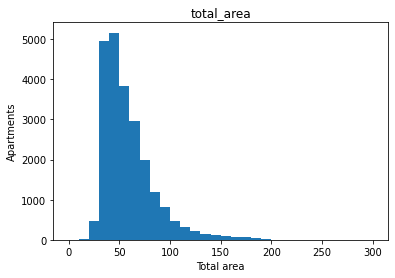

In [ ]:
plt.hist(x = real_estate_data['total_area'], bins=30, range = (0,300))
plt.xlabel('Total area')
plt.ylabel('Apartments')
plt.title('total_area')

На рынке преоблдают квартиры в пределах 50кв.м., чем выше площадь, тем реже встречаются в продаже

* жилая площадь


In [ ]:
real_estate_data['living_area'].describe()

count   21120.00
mean       33.13
std        16.75
min         8.00
25%        18.60
50%        30.00
75%        42.00
max       164.70
Name: living_area, dtype: float64

Text(0.5, 1.0, 'Living area')

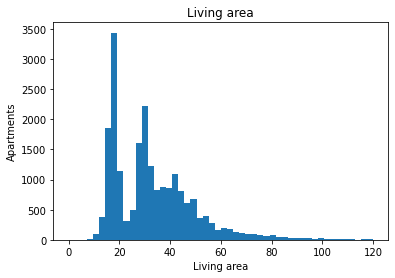

In [ ]:
plt.hist(x = real_estate_data['living_area'], bins=50, range = (0,120))
plt.xlabel('Living area')
plt.ylabel('Apartments')
plt.title('Living area')

На графике видно несколько пиков. Предположу это распределение в зависимости от количества комнат в квартире - студии и однокомнатные квартиры, далее двухкомнатные, далее трехкомнатные квартиры.

* площадь кухни

In [ ]:
real_estate_data['kitchen_area'].describe()

count   20948.00
mean       10.38
std         5.34
min         5.00
25%         7.00
50%         9.00
75%        11.90
max        93.20
Name: kitchen_area, dtype: float64

Text(0.5, 1.0, 'Kitchen area')

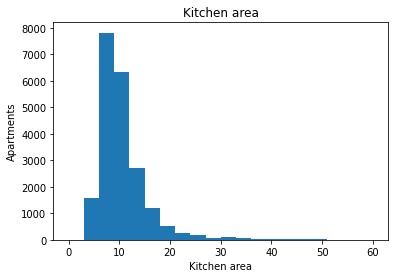

In [ ]:
plt.hist(x = real_estate_data['kitchen_area'], bins=20, range = (0,60))
plt.xlabel('Kitchen area')
plt.ylabel('Apartments')
plt.title('Kitchen area')

Большая часть кухонь 7-12кв.м.

* цена объекта

In [ ]:
real_estate_data['last_price'].describe()

count       22940.00
mean      6013642.00
std       6201294.50
min        430000.00
25%       3450000.00
50%       4600000.00
75%       6700000.00
max     330000000.00
Name: last_price, dtype: float64

Text(0.5, 1.0, 'Last price')

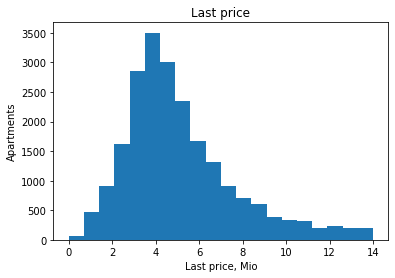

In [ ]:
plt.hist(x = real_estate_data['last_price']/1000000, bins=20, range = (0,14))
plt.xlabel('Last price, Mio')
plt.ylabel('Apartments')
plt.title('Last price')

Самая популярная цена около 4млн.руб.

* количество комнат

In [ ]:
real_estate_data['rooms'].describe()

count   22940.00
mean        2.04
std         0.95
min         1.00
25%         1.00
50%         2.00
75%         3.00
max         5.00
Name: rooms, dtype: float64

Text(0.5, 1.0, 'Rooms')

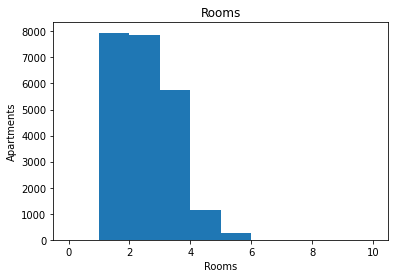

In [ ]:
plt.hist(x = real_estate_data['rooms'], bins=10, range = (0,10))
plt.xlabel('Rooms')
plt.ylabel('Apartments')
plt.title('Rooms')

Самые часты проджаи квартир с 1-2 комнатами

* высота потолков

In [ ]:
real_estate_data['ceiling_height'].describe()

count   22940.00
mean        2.69
std         0.30
min         1.00
25%         2.60
50%         2.65
75%         2.70
max        22.60
Name: ceiling_height, dtype: float64

Text(0.5, 1.0, 'Ceiling height')

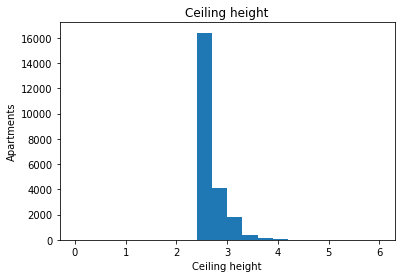

In [ ]:
plt.hist(x = real_estate_data['ceiling_height'], bins=20, range = (0,6))
plt.xlabel('Ceiling height')
plt.ylabel('Apartments')
plt.title('Ceiling height')

Самая распространенная высота потолка - 2.65м

* этаж квартиры

In [ ]:
real_estate_data['floor'].describe()

count   22940.00
mean        5.88
std         4.86
min         1.00
25%         2.00
50%         4.00
75%         8.00
max        33.00
Name: floor, dtype: float64

Text(0.5, 1.0, 'Floor ')

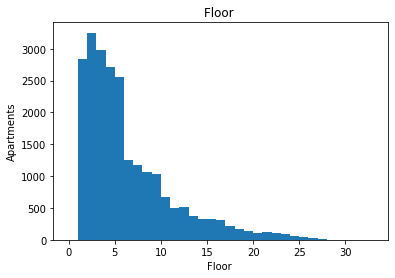

In [ ]:
plt.hist(x = real_estate_data['floor'], bins=33, range = (0,33))
plt.xlabel('Floor ')
plt.ylabel('Apartments')
plt.title('Floor ')

Большая часть квартир расположены в пределах 5 этажа

* тип этажа квартиры

In [ ]:
real_estate_data['type_floor'].describe()

count      22940
unique         3
top       другой
freq       16903
Name: type_floor, dtype: object

Text(0.5, 1.0, 'Type floor')

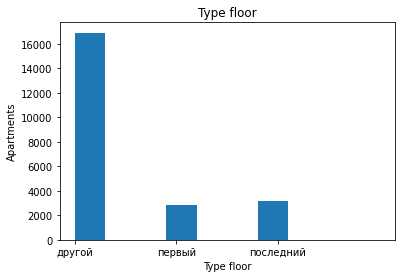

In [ ]:
plt.hist(x = real_estate_data['type_floor'], bins=10, range = (0,3))
plt.xlabel('Type floor')
plt.ylabel('Apartments')
plt.title('Type floor')

Квартиры на последнем этаже выставляют на продажу чаще, чем на первом этаже. Возможно небольшая часть людей понимает, что первый этаж можно перевести в коммерческую недвижимость, а также в этом жилье нет протечек с крыши.

* общее количество этажей в доме

In [ ]:
real_estate_data['floors_total'].describe()

count   22940.00
mean       10.69
std         6.55
min         1.00
25%         5.00
50%         9.00
75%        16.00
max        35.00
Name: floors_total, dtype: float64

Text(0.5, 1.0, 'Floors total')

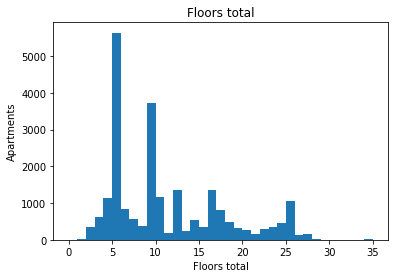

In [ ]:
plt.hist(x = real_estate_data['floors_total'], bins=35, range = (0,35))
plt.xlabel('Floors total')
plt.ylabel('Apartments')
plt.title('Floors total')

Самые распространенные дома в СПб и Лен.обл. 5, 9, 10, 12, 17 этажей

* расстояние до центра города в метрах

In [ ]:
real_estate_data['city_сenters_nearest'].describe()

count   17558.00
mean    14312.88
std      8574.51
min       181.00
25%      9488.00
50%     13166.50
75%     16318.00
max     65968.00
Name: city_сenters_nearest, dtype: float64

Text(0.5, 1.0, 'City centers nearest')

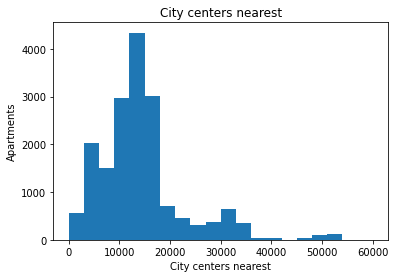

In [ ]:
plt.hist(x = real_estate_data['city_сenters_nearest'], bins=20, range = (0,60000))
plt.xlabel('City centers nearest')
plt.ylabel('Apartments')
plt.title('City centers nearest')

В среднем до центра 13км

* расстояние до ближайшего аэропорта

In [ ]:
real_estate_data['airports_nearest'].describe()

count   17538.00
mean    28881.76
std     12673.95
min         0.00
25%     18500.75
50%     26935.50
75%     37407.00
max     84869.00
Name: airports_nearest, dtype: float64

Text(0.5, 1.0, 'Airports nearest')

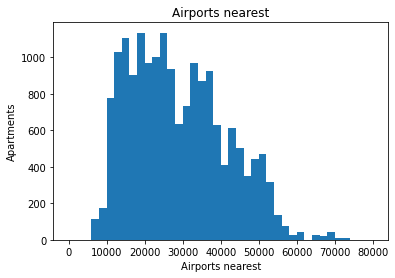

In [ ]:
plt.hist(x = real_estate_data['airports_nearest'], bins=40, range = (0,80000))
plt.xlabel('Airports nearest')
plt.ylabel('Apartments')
plt.title('Airports nearest')

На графике прослеживаются ближайшие районы от которых до аэропорта от 10 до 26км

* расстояние до ближайшего парка

In [ ]:
real_estate_data['parks_nearest'].describe()

count   7766.00
mean     492.06
std      343.80
min        1.00
25%      288.00
50%      456.00
75%      613.00
max     3190.00
Name: parks_nearest, dtype: float64

Text(0.5, 1.0, 'Parks nearest')

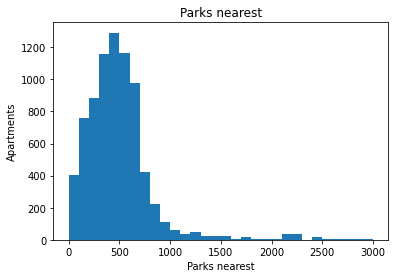

In [ ]:
plt.hist(x = real_estate_data['parks_nearest'], bins=30, range = (0,3000))
plt.xlabel('Parks nearest')
plt.ylabel('Apartments')
plt.title('Parks nearest')

Квартиры с указанием парка часто находятся достаточно рядом, всего 500м

* день и месяц публикации объявления

Построю гистограмму по дням

Text(0.5, 1.0, 'Week first exposition')

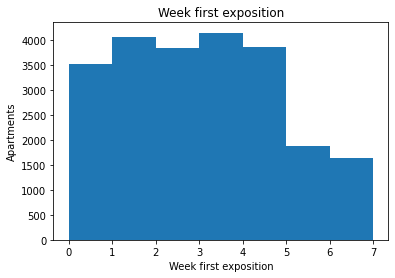

In [ ]:
plt.hist(x = real_estate_data['week_first_exposition'], bins=7, range = (0,7))
plt.xlabel('Week first exposition')
plt.ylabel('Apartments')
plt.title('Week first exposition')

Вторник и четверг самые активные дни с публикациями, реже публикации выходят на выходных

Построю гистограмму по месяцам

Text(0.5, 1.0, 'Month first exposition')

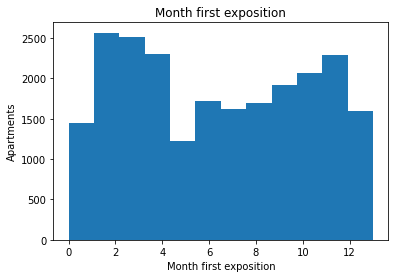

In [ ]:
plt.hist(x = real_estate_data['month_first_exposition'], bins=12, range = (0,13))
plt.xlabel('Month first exposition')
plt.ylabel('Apartments')
plt.title('Month first exposition')

Активность публикаций начинается с февраля, ослабевает к апрелю, и противоположный тренд с сентября по ноябрь. Май - наименее активный месяц. В России майские праздники - время праздников, путешесвий и открытия дачного сезона.

#### Как быстро продавались квартиры

Построю график

In [ ]:
replace_spaces = real_estate_data.replace(r'^\s*$', np.nan, regex=True) #замена NA на NaN

<AxesSubplot:>

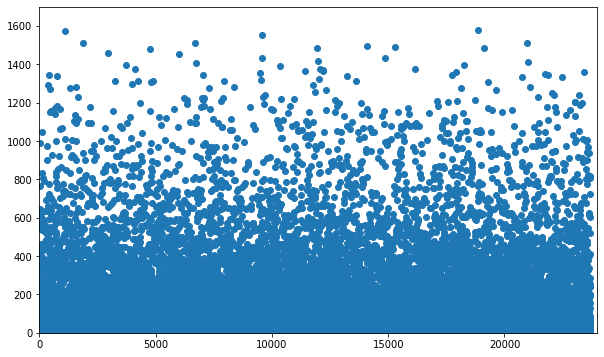

In [ ]:
replace_spaces['days_exposition'].plot(xlim=(0, 24000), ylim=(0, 1700), style='o', figsize=(10,6))

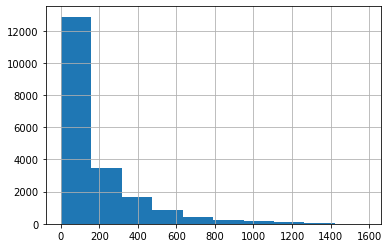

In [ ]:
replace_spaces['days_exposition'].hist();

In [ ]:
#plt.hist(x = replace_spaces['days_exposition'], bins=50, range = (0,500))
#plt.xlabel('Days exposition')
#plt.ylabel('Apartments')
#plt.title('Days exposition')

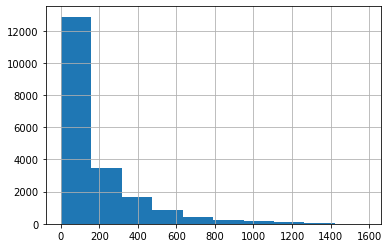

In [ ]:
real_estate_data['days_exposition'].hist();

Выведу среднее значение и медиану

In [ ]:
real_estate_data['days_exposition'].describe()

count   19879.00
mean      180.04
std       218.53
min         1.00
25%        45.00
50%        95.00
75%       230.00
max      1580.00
Name: days_exposition, dtype: float64

Большая часть квартир продается за менее, чем за 95 дней. Срок до 45 дней можно назвать быстрой продажей, долгой свыше 232 дней.

#### Факторы больше всего влияющие на общую (полную) стоимость объекта

Для начала для наглядности построю тепловую карту

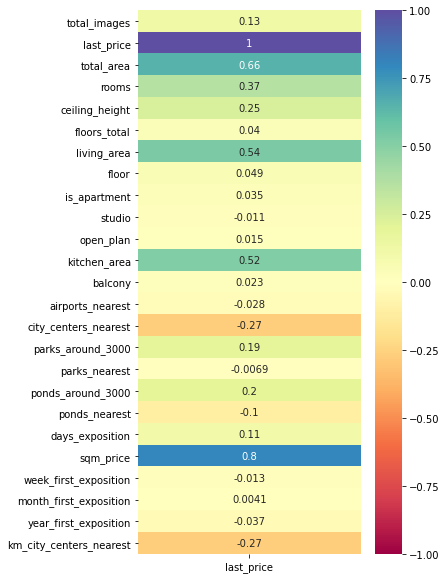

In [ ]:
plt.figure(figsize=(5, 10))
sns.heatmap(real_estate_data.corr()[['last_price']], cmap="Spectral", vmin=-1, vmax=1, annot=True);

В большей степени на полную стоимость объекта влиют площади - общая, жилая,кухни, также число комнат и высота потолков.

Выведу матрицу корреляции и тотечные диаграммы

                        last_price  total_area  living_area  kitchen_area  \
last_price                    1.00        0.66         0.54          0.52   
total_area                    0.66        1.00         0.92          0.56   
living_area                   0.54        0.92         1.00          0.31   
kitchen_area                  0.52        0.56         0.31          1.00   
rooms                         0.37        0.78         0.87          0.18   
week_first_exposition        -0.01       -0.02        -0.01         -0.01   
month_first_exposition        0.00        0.01         0.00          0.00   
year_first_exposition        -0.04       -0.09        -0.07         -0.05   

                        rooms  week_first_exposition  month_first_exposition  \
last_price               0.37                  -0.01                    0.00   
total_area               0.78                  -0.02                    0.01   
living_area              0.87                  -0.01              

array([[<AxesSubplot:xlabel='last_price', ylabel='last_price'>,
        <AxesSubplot:xlabel='total_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='living_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='rooms', ylabel='last_price'>,
        <AxesSubplot:xlabel='week_first_exposition', ylabel='last_price'>,
        <AxesSubplot:xlabel='month_first_exposition', ylabel='last_price'>,
        <AxesSubplot:xlabel='year_first_exposition', ylabel='last_price'>],
       [<AxesSubplot:xlabel='last_price', ylabel='total_area'>,
        <AxesSubplot:xlabel='total_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='living_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='kitchen_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='rooms', ylabel='total_area'>,
        <AxesSubplot:xlabel='week_first_exposition', ylabel='total_area'>,
        <AxesSubplot:xlabel='month_first_exposition', ylabel='

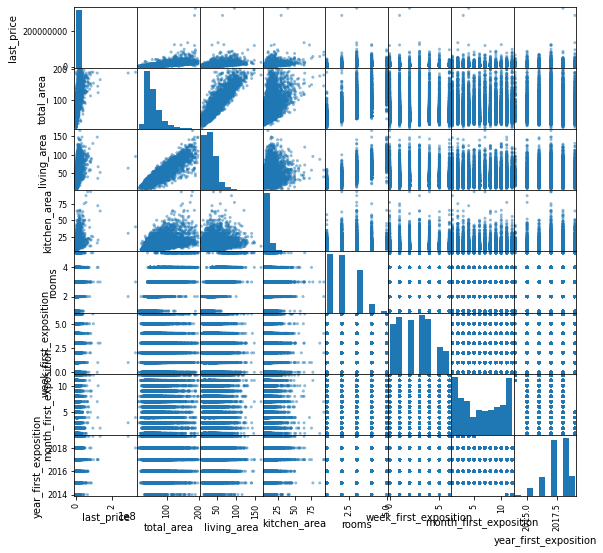

In [ ]:
red = real_estate_data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'type_floor', 'week_first_exposition', 'month_first_exposition', 'year_first_exposition']]
print(red.corr())
pd.plotting.scatter_matrix(red, figsize=(9,9))

Зависимость цены от общей площади квартиры

In [ ]:
real_estate_data['mln_last_price']=real_estate_data['last_price']/1000000

<AxesSubplot:xlabel='total_area'>

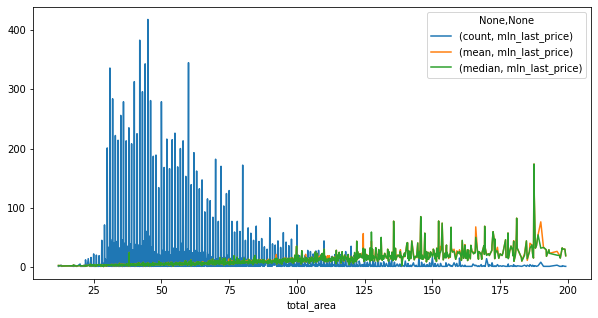

In [ ]:
real_estate_data.pivot_table(index='total_area', values='mln_last_price', aggfunc=['count', 'mean', 'median']).plot(figsize=(10, 5))

Графику немного не хватает аппроксимации. В целом прослеживается линейная зависимость, чем больше площадь, тем выше цена.

Зависисмость цены от жилой площади

<AxesSubplot:xlabel='living_area'>

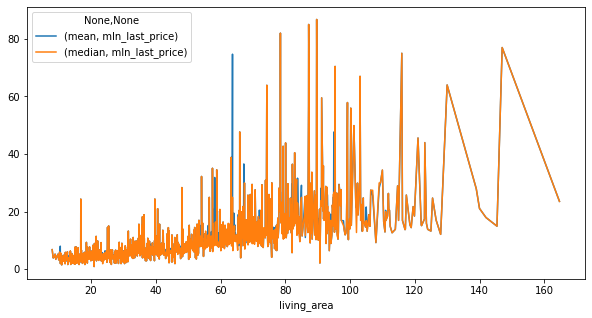

In [ ]:
real_estate_data.pivot_table(index='living_area', values='mln_last_price', aggfunc=[ 'mean', 'median']).plot(figsize=(10, 5))

Также прослеживается линейная зависимость, но наклон линии медианы ниже, а значит зависимость между ценой и жилой площадью чуть более слабая, по сравнению с зависимостью цены от общей площади.

Зависисмость цены от площади кухни

<AxesSubplot:xlabel='kitchen_area'>

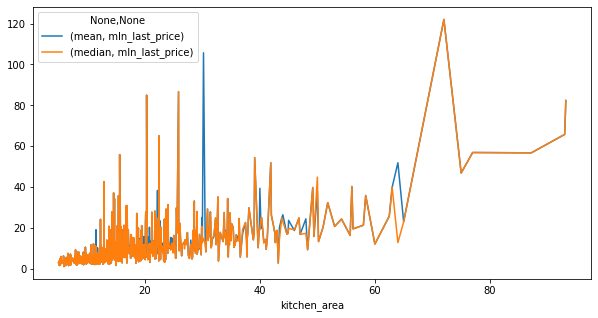

In [ ]:
real_estate_data.pivot_table(index='kitchen_area', values='mln_last_price', aggfunc=['mean', 'median']).plot(figsize=(10, 5))

На данном графике еще меньше волатильности, а также наклон медианы чуть ниже, зависимость цены от площади кухни есть, но чуть более слабая

Scatter plot

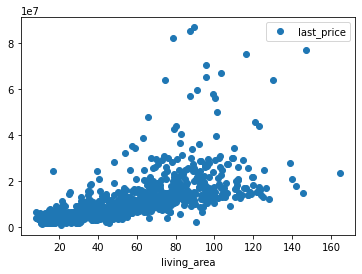

In [ ]:
real_estate_data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = 'median').plot(style='o');

Зависисмость цены от количества комнат

<AxesSubplot:xlabel='rooms'>

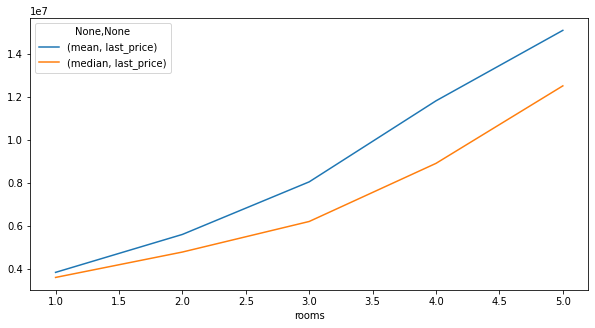

In [ ]:
real_estate_data.pivot_table(index='rooms', values='last_price', aggfunc=['mean', 'median']).plot(figsize=(10, 5))

Более выраженная корредяция между ценой и количеством комнат начинается в объектах с 4 и более комнат.

Зависимость цены от этажа, на котором расположена квартира

<AxesSubplot:xlabel='type_floor'>

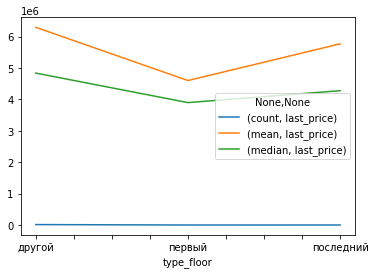

In [ ]:
real_estate_data.pivot_table(index='type_floor', values='last_price', aggfunc=['count', 'mean', 'median']).plot()

Квартиры на первом и последнем этажах дешевле, чем на других.

Зависимость цены от даты размещения (неделя)

<AxesSubplot:xlabel='week_first_exposition'>

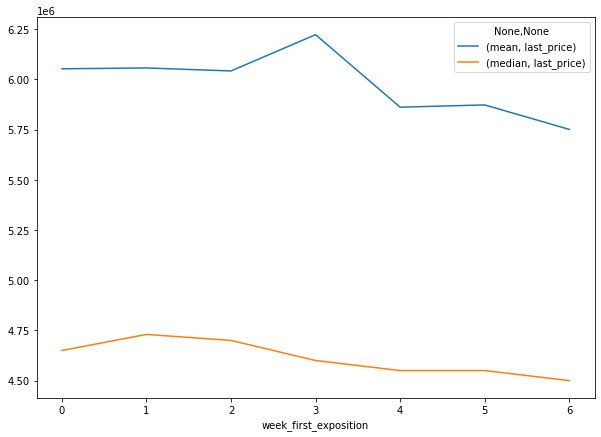

In [ ]:
real_estate_data.pivot_table(index='week_first_exposition', values='last_price', aggfunc=['mean', 'median']).plot(figsize=(10,7))

Зависимости почти нет(линия медианы почти параллельна оси x), при публикации во вторник цена чуть выше, чем в остальные дни.

Зависимость цены от даты размещения (месяц)

<AxesSubplot:xlabel='month_first_exposition'>

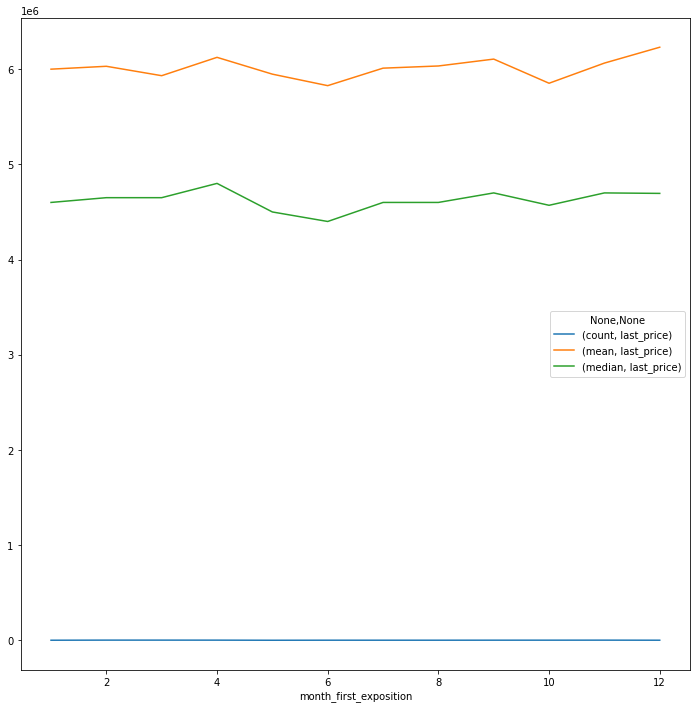

In [ ]:
real_estate_data.pivot_table(index='month_first_exposition', values='last_price', aggfunc=['count', 'mean', 'median']).plot(figsize=(12, 12))

Зависимости цены от месяца публикации также особо нет, цена при публикации в апреле чуть выше, в июне цена чуть ниже.

Зависимость цены от даты размещения (месяц)

<AxesSubplot:xlabel='year_first_exposition'>

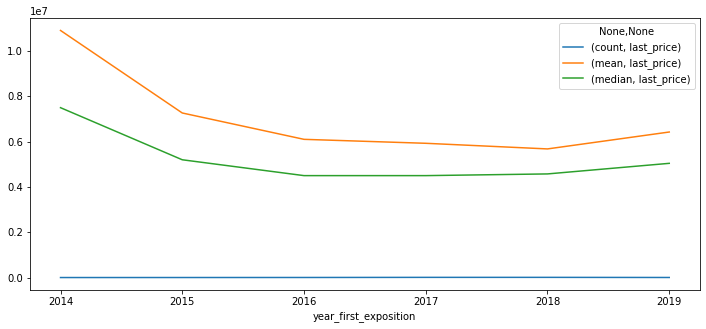

In [ ]:
real_estate_data.pivot_table(index='year_first_exposition', values='last_price', aggfunc=['count', 'mean', 'median']).plot(figsize=(12,5))

Выведу первую и последнюю публикации

In [ ]:
real_estate_data['first_day_exposition'].min()

Timestamp('2014-11-27 00:00:00')

In [ ]:
real_estate_data['first_day_exposition'].max()

Timestamp('2019-05-03 00:00:00')

В сете данные с ноября 2014 года по май 2019 года. Корректно сравнивать полный год с полным годом (с 2015 год по 2018 год). Самые низкие цены при размещении в 2016 году.

<div style="border:solid Purple 2px; padding: 40px">
    Вывод. В первую очередь на цену влияет площадь, как общая так и жилая. 4х.к. квартиры и более комнат начинают влиять на цену в сторону удорожания, причем достаточно волатильно. Это может быть связано как с тем, что не все выбросы (сегмент premium) были удалены, так и с отличиями в потребностях у представителей wealthy class, которые более взыскательны и могут себе позволить уникальность. День и месяц публикации почти не имели значения. Год имел небольшое значение, самая низкая цена была в 2016 году. Это может быть связано с экономической ситуацией на рынке, которая влияет на кривую спроса-предложения.

#### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Сформирую сводную таблицу и отсортирую наеленные пункты

In [ ]:
real_estate_data.pivot_table(index='locality_name', values='sqm_price', aggfunc={'count','median'}).sort_values(by='count', ascending=False).head(20)

,count,median
locality_name,,
Санкт-Петербург,15185,104534.01
посёлок Мурино,522,84192.74
посёлок Шушары,434,76666.67
Всеволожск,392,65789.47
Пушкин,360,100000.00
Колпино,337,74722.22
посёлок Парголово,322,91984.44
Гатчина,302,67925.85
деревня Кудрово,283,91666.67


Ранее писала, что некоторые районы СПб в сете выгрузились отдельно(например, Шушары, Пушкин - это Пушкинский район СПб), как будто это населенные пункты, поэтому вывела 20 строк, чтобы захватить, например Кириши.

<div style="border:solid Purple 2px; padding: 40px">
    Вывод. Самое дорогое жилье в СПб и ряде его районов. В Лен. обл. одним из самых дорогих районов является Всеволожск.
    </div>

#### Вычислите среднюю цену каждого километра в Санкт-Петербурге

Сформирую сводную таблицу в срезе по СПб и построю график

<AxesSubplot:xlabel='km_city_сenters_nearest'>

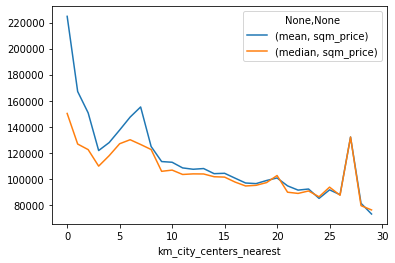

In [ ]:
real_estate_data.query('locality_name == "Санкт-Петербург"').pivot_table(index='km_city_сenters_nearest', values='sqm_price', aggfunc=['mean','median']).plot()

Самая высокая цена в радиусе 4км от центра.

<div style="border:solid Purple 2px; padding: 40px">
    Вывод. Цена падает с удаленностью от центра СПб, но пики подсказывают, что видимо есть районы, которые несмотря на отдаленность от центра имеют привлекательность для покупателей.
    </div>

### Общий вывод

Рекомендуется выгружать и анализировать данные по СПб и Лен. обл. таким образом, чтобы тип и название населенного пункта были отделены друг от друга. В СПб стоит по адресу определять район, т.к. не только близость центра влияет на цену недвижимости, но расположение в определенном районе. Также сегмент premium рассматривать отдельно от сегмента econom.

В ходе выполнения проекта были выполнены этапы:

1. Изучена общая информация о полученном датафрейме.
В сете представлены объявления с основными параметрами за несколько лет о продаже квартир в Санкт-Петербурге и Ленинградской области.
Предстояло разобраться с пропусками, аномальными значениями, чтобы иметь возможность найти зависимости, которые существуют на рынке недвижимости. Большая часть объектов расположена в Санкт-Петербурге и его районах (часть вынесены в отдельные строки)

2. Проведена предобработка данных
2.1  Явных дубликатов не было, но были удалены неявные дубликаты, например посёлок мог иметь написание "поселок"
2.2  Были выявлены редкие значения:
Встерчалась высота потолков менее 2,4м или выше 20м. Часть значений были удалены, часть откорректированы в виду предполагаемой ошибки ввода данных;
Аномальная стоимость квартиры - 12тыс.руб. или слишком выбивающаяся из всех значений - 763млн. Такие аномалии были удалены;
Данные, где квартиры имели жилую площадью 0; 2; 3 кв.м.; квартиры-студии были менее 18кв.м. и квартиры с кухней менее 5кв.м. были удалены.
Встречалось число комнат равное нулю. Такие значения вместе с выбросами более 6 комнат были удалены.
В городе самый высокий объект с жилой недвижимостью не превышает 35 этажей, данные выше этой величины были удалены.
2.3  Типы данных
Многие значения float64 и object были заменены на float32, bool, int64, datatime.
2.4  Пропущенные значения в столбцах
Часть картографических данных (например, число водоемов и парков в радиусе 3км) имеют сходное количество пропусков. Вероятно дело в некорректной выгрузке.
Часть значений не были заполнены пользователями. Некоторые пропуски, например количесвто балконов, были заменены на нули исходя из логики - не указан балкон, скорее всего его нет.
Пропуск с населенным пунктом не представляется возможным заменить.
Пропущенные значения высоты потолков были заменены медианой.

3.  Посчитаны и добавлены новые столбцы
3.1  Цена одного квадратного метра - медиана 95тыс.руб. за кв.м.
3.2  День недели публикации объявления - чаще публикуют в четверг
3.4  Год публикации объявления - большая часть объявлений опубликована в 2018году.
        
4.  Проведен исследовательский анализ данных
4.1  Изучены следующие параметры объектов: общая площадь; жилая площадь;площадь кухни;цена объекта;количество комнат;высота отолков; этаж квартиры; тип этажа квартиры («первый», «последний», «другой»); общее количество этажей в доме; расстояние до центра города в метрах; расстояние до ближайшего аэропорта; расстояние до ближайшего парка; день и месяц публикации объявления.
4.2  Как быстро продавались квартиры
Большая часть квартир продается за менее, чем за 95 дней. Срок до 45 дней можно назвать быстрой продажей, долгой свыше 232 дней.
4.3  Факторы больше всего влияющие на общую (полную) стоимость объекта
Между общей, жилой площадью и ценой прослеживается линейная зависимость, чем больше площадь, тем выше цена. Площадь кухни в меньшей степени влияет на цену квартиры. С ростом количества комнат растет цена квартиры.
Квартиры на первом и последнем этажах дешевле, чем на других.
4.4  Посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
Самое дорогое жилье в СПб, средняя цена - 105тыс. за кв.м и ряде его районов. В Лен. обл. одним из самых дорогих районов является Всеволожск, средняя цена - 66тыс. за кв.м.
4.5  Рассчитана средняя цена каждого километра в Санкт-Петербурге
Самая высокая цена в радиусе 4км от центра.


   


Общий вывод

В сете были представлены объекты недвижимости СПб и Лен. обл. На рынке преобладают 1-3 комнатные квартиры. Средняя площадь - 52 кв.м. Минимальная цена за квадратный метр - 7,9 тыс. руб., средняя цена - 95 тыс. руб. за кв.м. Самое дорогое жилье в радиусе 4 км. от центра Санкт-Петербурга. Стоит отметить, расположение в определенном районе тажке влияет на стоимость квартиры. Публикация в среднем висит не более 95 дней.